In [5]:
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

# Load the dataset
#Atlanta_Distance = pd.read_pickle(r'~/Documents/NYCDSA/Capstone/Pickle Files/Atlanta_Nearest_POI.pkl')
Atlanta_Distance = pd.read_csv('~/Documents/NYCDSA/Capstone/Nearest_Distances_Atlanta/Atlanta_Nearest_Distances.csv')
Atlanta_Distance['Total Bathrooms'] = Atlanta_Distance['number_of_full_baths'] + (Atlanta_Distance['number_of_half_baths']*0.5)
Atlanta_Distance = Atlanta_Distance.drop(columns=['ID', 'year_built', 'source_name',
                                                  'listing_date', 'mls_id', 'census_zcta5_geoid',
                                                  'census_cbsa_geoid', 'latitude', 'longitude', 'lot_size_in_acres', 'number_of_full_baths', 'number_of_half_baths'])
Atlanta_Distance = Atlanta_Distance.rename(columns={'Distance_SM': 'Supermarket', 'Distance_C': 'Convenience',
'Distance_WS': 'Wholesale', 'Distance_VS': 'Variety Store', 'Distance_SC': 'Supercenter', 'number_of_bedrooms': 'Total Bedrooms', 'living_area_square_feet': 'Living Area(SQF)',
                                                   'lot_size_in_square_feet': 'Lot Size(SQF)', 'number_of_garage_spaces': 'Garage Spaces', 'number_of_stories': 'Stories'})
Atlanta_Distance

,street_address,city,state,current_listing_price,Total Bedrooms,Living Area(SQF),Lot Size(SQF),has_pool,has_garage,Garage Spaces,...,Supercenter,Convenience_POI,Convenience,Supermarket_POI,Supermarket,Variety_store_POI,Variety Store,Wholesale_POI,Wholesale,Total Bathrooms
0,0 ivy MNR DR NW 0,Marietta,GA,2865,4,3259.0,14810.400390,False,True,NaN,...,2539.28,Sunoco,2715.74,Kroger,1654.08,Bargain Hunt,6405.99,Atlanta Wholesale,10917.45,2.5
1,1 10 buena VIS CIR SE,Cartersville,GA,2200,3,1993.0,NaN,False,False,NaN,...,492.63,Mack's Express,1407.26,Publix,3065.55,Dollar Tree,405.11,LI Global Liquidation,32739.68,2.0
2,1 1088 coldwater DR,Griffin,GA,2000,3,1910.0,NaN,False,True,NaN,...,25413.80,Unnamed POI,3213.19,Kroger,3780.13,Dollar General,4738.04,Costco,29267.11,2.0
3,1 1130 willivee DR,Decatur,GA,1995,3,1134.0,NaN,False,False,NaN,...,7857.71,Food Mart,2385.60,Publix,2320.59,Dollar Tree,4356.55,Sam's Club,9020.53,1.0
4,1 1307 idlewood CT,Mcdonough,GA,2800,4,2532.0,NaN,False,True,NaN,...,11676.91,Crossings at McDonough,14263.22,Kroger,5625.35,Dollar Tree,6721.22,Costco,14750.79,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21025,procurement only - 66 4th ST,Newnan,GA,1600,3,1367.0,NaN,False,True,NaN,...,19852.16,Newnan Lakes Chevron,4983.93,Little Giant Supermaket,2097.35,Family Dollar,6409.21,Two Valleys Distribution,47285.12,2.0
21026,r2188 executive DR,Duluth,GA,2199,3,1696.0,871.199981,False,False,NaN,...,4864.86,Unnamed POI,1477.04,Mega Mart,888.22,Dollar Tree,6142.54,Sam's Club,2009.36,2.5
21027,r3339 woodward down,Buford,GA,2380,3,1944.0,4356.000065,False,False,NaN,...,1359.41,Walgreens,3952.51,ALDI,1158.08,Five Below,714.63,Sam's Club,1507.23,3.5
21028,singleunit 216 greensprings DR,Palmetto,GA,1900,4,1204.0,NaN,False,False,NaN,...,10787.35,Flash Foods,1242.13,Publix,8779.81,Family Dollar,1402.52,Costco,40632.51,2.0


In [6]:
# Exclude 'current_listing_price' from features
numeric_features = Atlanta_Distance.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
#categorical_features = list(Atlanta_Distance.columns[Atlanta_Distance.dtypes == 'object'])

In [7]:
# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for nominal categorical features: Fill missing values with 'None' then apply one-hot encoding
#categorical_transformer = Pipeline(steps=[
    #('impute_none', SimpleImputer(strategy='constant', fill_value='None')),  # Using SimpleImputer
    #('onehot', OneHotEncoder(handle_unknown='ignore'))
#])

# Combined preprocessor for numeric and nominal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('nominal', categorical_transformer, categorical_features)
])

transformed_data = preprocessor.fit_transform(Atlanta_Distance)

In [8]:
# Generate column names for the one-hot encoded features
#onehot_features = preprocessor.named_transformers_['nominal'].named_steps['onehot'].get_feature_names_out()
# Combine all feature names
all_feature_names = list(numeric_features)
all_feature_names

['Total Bedrooms',
 'Living Area(SQF)',
 'Lot Size(SQF)',
 'Garage Spaces',
 'Stories',
 'Supercenter',
 'Convenience',
 'Supermarket',
 'Variety Store',
 'Wholesale',
 'Total Bathrooms']

In [9]:
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)
transformed_df

,Total Bedrooms,Living Area(SQF),Lot Size(SQF),Garage Spaces,Stories,Supercenter,Convenience,Supermarket,Variety Store,Wholesale,Total Bathrooms
0,0.641597,1.314458,-0.032969,-7.852818e-16,4.979361e-03,-0.853173,-0.558145,-0.543492,0.542177,-0.636596,0.050686
1,-0.459495,0.111649,0.000000,-7.852818e-16,-3.328122e-17,-1.210464,-0.973201,-0.086966,-1.156373,1.494897,-0.167469
2,-0.459495,0.032791,0.000000,-7.852818e-16,-3.328122e-17,3.140114,-0.400352,0.144158,0.070063,1.155713,-0.167469
3,-0.459495,-0.704476,0.000000,-7.852818e-16,-3.328122e-17,0.075285,-0.662867,-0.327916,-0.037918,-0.821878,-0.603778
4,0.641597,0.623745,0.000000,-7.852818e-16,-3.328122e-17,0.742016,3.104770,0.740976,0.631403,-0.262173,-0.167469
...,...,...,...,...,...,...,...,...,...,...,...
21025,-0.459495,-0.483106,0.000000,-7.852818e-16,-3.328122e-17,2.169198,0.161335,-0.400121,0.543088,2.915627,-0.167469
21026,-0.459495,-0.170527,-0.033365,-7.852818e-16,-3.328122e-17,-0.447188,-0.951067,-0.791202,0.467607,-1.506697,0.050686
21027,-0.459495,0.065094,-0.033266,-7.852818e-16,-3.328122e-17,-1.059147,-0.165836,-0.703919,-1.068764,-1.555742,0.486995
21028,0.641597,-0.637970,0.000000,-7.852818e-16,-3.328122e-17,0.586722,-1.025581,1.761256,-0.874056,2.265832,-0.167469


In [10]:
from xgboost import XGBRegressor
# Assuming RandomForest is part of your models dictionary
xgb_model = XGBRegressor(random_state=42)
# Define the full model pipeline including the preprocessor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])
X = Atlanta_Distance.drop(columns='current_listing_price')
y = Atlanta_Distance['current_listing_price']
# Fit the model pipeline
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Total Bedrooms', 'Living Area(SQF)', 'Lot Size(SQF)', 'Garage Spaces',
       'Stories', 'Supercenter', 'Convenience', 'Supermarket', 'Variety Store',
       'Wholesale', 'Total Bathrooms'],
      dtype='object'))])),
                ('regressor',...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [11]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cross_val_score_gb = cross_val_score(pipeline, X, y, scoring = 'r2', cv=kf, n_jobs = -1)
print(cross_val_score_gb)
print('Avg Score:',np.mean(cross_val_score_gb))
print('Variance:',np.var(cross_val_score_gb))

[0.60958699 0.55375405 0.58836383 0.598429   0.59785304 0.63082669
 0.59351436 0.57587751 0.57261043 0.55916666]
Avg Score: 0.5879982556711587
Variance: 0.0004924450387381471


In [12]:
param_grid = {
    'regressor__n_estimators': [3000],       # Number of trees
    'regressor__learning_rate': [0.1],     # Learning rate (shrinkage)
    'regressor__max_depth': [None],                # Maximum depth of the trees
    'regressor__subsample': [0.8],               # Fraction of samples to be used per tree
    'regressor__colsample_bytree': [1.0],        # Fraction of features to be used per tree
    'regressor__gamma': [0]                 # Minimum loss reduction for a split
}

grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='r2', n_jobs=-1)
grid_search.fit(X, y)
# Print the best hyperparameters found by the grid search
print("Best hyperparameters:", grid_search.best_params_)

# Print the best cross-validation score (negative MSE)
print("Best cross-validation score (R2):", grid_search.best_score_)

Best hyperparameters: {'regressor__colsample_bytree': 1.0, 'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': None, 'regressor__n_estimators': 3000, 'regressor__subsample': 0.8}
Best cross-validation score (R2): 0.63539347883034


In [13]:
best_xgb_model = grid_search.best_estimator_.named_steps['regressor']
feature_importances = best_xgb_model.feature_importances_

In [14]:
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = np.array(all_feature_names)[sorted_indices]

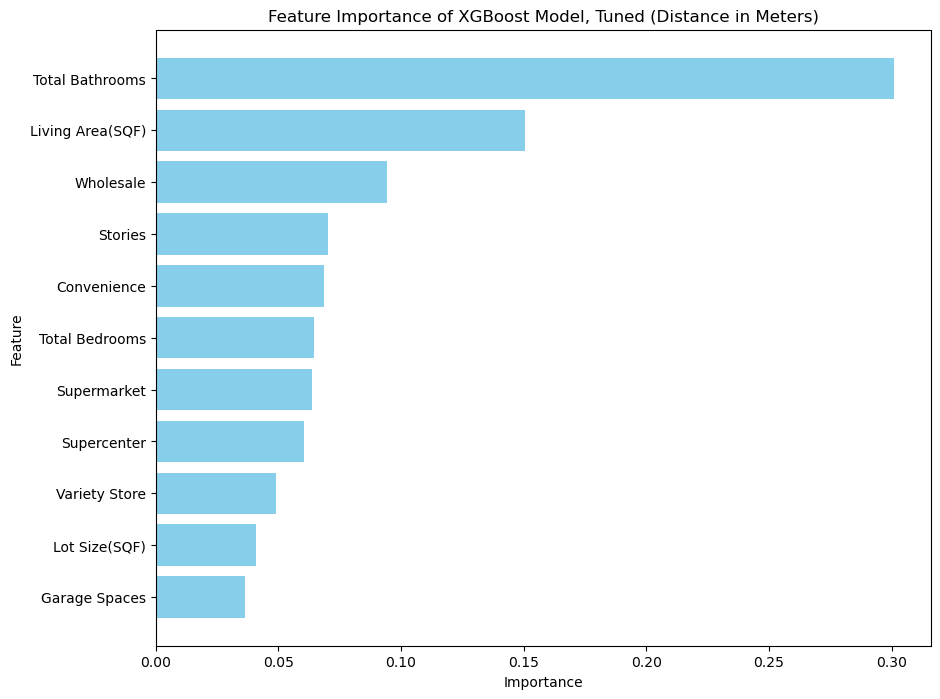

In [17]:
# Create a bar chart for feature importance
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, sorted_feature_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of XGBoost Model, Tuned (Distance in Meters)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()